In [12]:
%matplotlib inline

import itertools
import datetime as dt
import calendar
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap

HEADER_INDICATOR = '66666'
DATE_FORMAT = '%Y%m%d%H'
PLOTTED_DATE_FORMAT = '%d-%m-%y %H:%M'
LOCATION_PADDING = 20.0
LINE_INTERVAL = 20.0
LATITUDE_OFFSET = 0.0
LONGITUDE_OFFSET = 0.0
PLOT_DIRECTORY = 'plots'

def get_key_by_index(ordered_dict, index):
    return next(itertools.islice(ordered_dict, index, index + 1))

def get_value_by_index(ordered_dict, index):
    return ordered_dict[get_key_by_index(ordered_dict, index)]

def get_pair_by_index(ordered_dict, index):
    return next(itertools.islice(ordered_dict.items(), index, index + 1))

def format_date(date_string):
    return dt.datetime.strptime(('19' if 18 <= int(date_string[:2]) <= 99 else '20') + date_string, DATE_FORMAT)

def format_feature(feature_key):
    return ' '.join(feature_key[:-1].split('_')).title()

def get_typhoon_by_id(id_number):
    return typhoons[id_number]

def get_typhoon_by_index(index):
    return get_value_by_index(typhoons, index)

def load_typhoons(file):
    current_typhoon = None
    with open(file) as data:
        for line in data:
            split_line = line.split()
            split_line_length = len(split_line)

            if split_line_length == 0:
                continue

            if split_line_length >= 2 and split_line[0] == HEADER_INDICATOR:
                typhoons[int(split_line[1])] = {}
                current_typhoon = get_typhoon_by_index(len(typhoons) - 1)

                if split_line[-2][0] in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
                    current_typhoon['name'] = split_line[-2].capitalize()

                else:
                    current_typhoon['name'] = 'Unnamed'

                current_typhoon['dates'] = []
                current_typhoon['latitudes'] = []
                current_typhoon['longitudes'] = []
                current_typhoon['pressures'] = []
                current_typhoon['wind_speeds'] = []
                continue

            if current_typhoon:
                if split_line_length >= 1:
                    current_typhoon['dates'].append(format_date(split_line[0]))

                if split_line_length >= 4:
                    current_typhoon['latitudes'].append(float(split_line[3]) / 10)

                if split_line_length >= 5:
                    current_typhoon['longitudes'].append(float(split_line[4]) / 10)

                if split_line_length >= 6:
                    current_typhoon['pressures'].append(float(split_line[5]))

                if split_line_length >= 7:
                    current_typhoon['wind_speeds'].append(float(split_line[6]))

def plot_typhoon_by_id(*args):
    global typhoon_to_plot
    typhoon_to_plot = get_typhoon_by_id(args[0])
    _plot(*args[1:])

def plot_typhoon_by_index(*args):
    global typhoon_to_plot
    typhoon_to_plot = get_typhoon_by_index(args[0])
    _plot(*args[1:])

def _plot(*args):
    if len(typhoon_to_plot[args[0]]) == len(typhoon_to_plot[args[1]]) >= 1:
        plt.plot(typhoon_to_plot[args[0]], typhoon_to_plot[args[1]])

        plt.title('{} Against {} of Typhoon '.format(format_feature(args[1]), format_feature(args[0])) + typhoon_to_plot['name'])
        plt.xlabel(format_feature(args[0]))
        plt.ylabel(format_feature(args[1]))
        
        if args[0] == 'dates':
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(PLOTTED_DATE_FORMAT))
            plt.gcf().autofmt_xdate()
        
        elif args[1] == 'dates':
            plt.gca().yaxis.set_major_formatter(mdates.DateFormatter(PLOTTED_DATE_FORMAT))
            plt.gcf().autofmt_xdate()
        
        plt.show()

def plot_typhoon_path_by_id(id_number):
    typhoon_to_plot = get_typhoon_by_id(id_number)
    _plot_basemap()

def plot_typhoon_path_by_index(index):
    typhoon_to_plot = get_typhoon_by_index(index)
    _plot_basemap()
        
def _plot_basemap():
    if len(typhoon_to_plot['latitudes']) == len(typhoon_to_plot['longitudes']) >= 1:
        sorted_latitudes = sorted(typhoon_to_plot['latitudes'])
        sorted_longitudes = sorted(typhoon_to_plot['longitudes'])
        min_latitude = sorted_latitudes[0] - LOCATION_PADDING
        max_latitude = sorted_latitudes[-1] + LOCATION_PADDING
        min_longitude = sorted_longitudes[0] - LOCATION_PADDING
        max_longitude = sorted_longitudes[-1] + LOCATION_PADDING

        fig = plt.figure(figsize=(15,9))
        axes = fig.add_subplot(1, 1, 1)
        mapping = Basemap(llcrnrlon=min_longitude, llcrnrlat=min_latitude, urcrnrlon=max_longitude, urcrnrlat=max_latitude, projection='lcc', lat_0=(min_latitude+max_latitude)/2.0, lon_0=(min_longitude+max_longitude)/2.0, resolution='l', area_thresh=1000.0)

        mapping.plot(typhoon_to_plot['longitudes'], typhoon_to_plot['latitudes'], latlon=True, linewidth=1.5, color='b')
        mapping.plot(typhoon_to_plot['longitudes'][0], typhoon_to_plot['latitudes'][0], latlon=True, linewidth=1.5, color='g', marker='o')
        mapping.plot(typhoon_to_plot['longitudes'][-1], typhoon_to_plot['latitudes'][-1], latlon=True, linewidth=1.5, color='r', marker='o')

        mapping.drawcoastlines()
        mapping.drawcountries()
        mapping.drawparallels(np.arange(min_latitude + LATITUDE_OFFSET, max_latitude + LATITUDE_OFFSET, LINE_INTERVAL), labels=[1,1,0,0])
        mapping.drawmeridians(np.arange(min_longitude + LONGITUDE_OFFSET, max_longitude + LONGITUDE_OFFSET, LINE_INTERVAL), labels=[0,0,0,1])
        mapping.shadedrelief()
        axes.set_title('Path of Typhoon ' + typhoon_to_plot['name'])
        plt.show()

def plot_all_typhoon_paths(from_date=None, to_date=None, from_date_string=None, to_date_string=None, date_format=None, background=None, year=None, month=None):
    if not from_date:
        from_date = dt.datetime.min
    
    if not to_date:
        to_date = dt.datetime.max
        
    if date_format:
        if from_date_string:
            from_date = dt.datetime.strptime(from_date_string, date_format)
        
        if to_date_string:
            to_date = dt.datetime.strptime(to_date_string, date_format)
    
    filtered_typhoons = []
    latitudes = []
    longitudes = []

    for typhoon in typhoons.values():
        for date in typhoon['dates']:
            if date < from_date or date > to_date:
                break
        
        else:
            filtered_typhoons.append(typhoon)
            latitudes.append(typhoon['latitudes'])
            longitudes.append(typhoon['longitudes'])

    if not filtered_typhoons:
        return
    
    latitudes = sorted(itertools.chain.from_iterable(latitudes))
    longitudes = sorted(itertools.chain.from_iterable(longitudes))
    min_latitude = latitudes[0] - LOCATION_PADDING
    max_latitude = latitudes[-1] + LOCATION_PADDING
    min_longitude = longitudes[0] - LOCATION_PADDING
    max_longitude = longitudes[-1] + LOCATION_PADDING

    fig = plt.figure(figsize=(15,9))
    axes = fig.add_subplot(1, 1, 1)
    mapping = Basemap(llcrnrlon=min_longitude, llcrnrlat=min_latitude, urcrnrlon=max_longitude, urcrnrlat=max_latitude, projection='cyl', lat_0=(min_latitude+max_latitude)/2.0, lon_0=(min_longitude+max_longitude)/2.0, resolution='l', area_thresh=1000.0)

    for typhoon in filtered_typhoons:
        mapping.plot(typhoon['longitudes'], typhoon['latitudes'], latlon=True, linewidth=1.5, color='b')
        mapping.plot(typhoon['longitudes'][0], typhoon['latitudes'][0], latlon=True, linewidth=1.5, color='g', marker='o')
        mapping.plot(typhoon['longitudes'][-1], typhoon['latitudes'][-1], latlon=True, linewidth=1.5, color='r', marker='o')

    mapping.drawcoastlines()
    mapping.drawcountries()
    mapping.drawparallels(np.arange(min_latitude + LATITUDE_OFFSET, max_latitude + LATITUDE_OFFSET, LINE_INTERVAL), labels=[1,1,0,0])
    mapping.drawmeridians(np.arange(min_longitude + LONGITUDE_OFFSET, max_longitude + LONGITUDE_OFFSET, LINE_INTERVAL), labels=[0,0,0,1])
    
    if background:
        getattr(mapping, background)()
    
    else:
        mapping.shadedrelief()
    
    if year and month:
        axes.set_title('Paths of All Typhoons Occurring in {} {}'.format(calendar.month_abbr[month], year))
        plt.savefig('{}/typhoons_{}-{}.png'.format(PLOT_DIRECTORY, year, month), transparent=True, bbox_inches='tight')
    
    plt.show()
    return len(filtered_typhoons)

def plot_all_typhoon_paths_per_month(year, **kwargs):
    return [plot_all_typhoon_paths(from_date=dt.datetime(year, month, 1), to_date=dt.datetime(year, month, calendar.monthrange(year, month)[1]), year=year, month=month, **kwargs) for month in range(1, 13)]

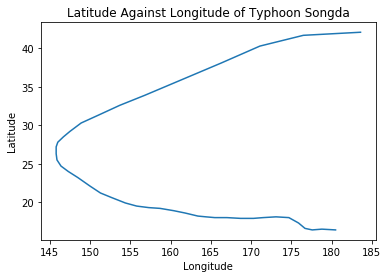

In [13]:
typhoons = OrderedDict()
load_typhoons('bst_all.txt')
plot_typhoon_by_id(1620, 'longitudes', 'latitudes')

# for year in range(2016, 2017):
#     plot_all_typhoon_paths_per_month(year)